In [47]:
import numpy as np
np.set_printoptions(threshold=np.inf)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import random
from pandas.plotting import parallel_coordinates

In [2]:
AV = [0, 20, 0, 0, 0, 0]
IV = [30, 45, 60, 40, 40, 40]
DO = [15, 20, 25, 15, 20, 25]
N = 240
V = 441
x1 = 21
x2 = 21
nsrcs = 6

In [3]:
# Generate data using given vectors
def createTC(av, iv, do):
    TCn = np.zeros(N, dtype=int)
    inc = N/iv
    while inc >= 1:
        for j in range(do):
            TCn[av+j] = 1
        av = av + iv
        inc -= 1
    
    return TCn

TCL = []
for i in range(nsrcs):
    av = AV[i]
    iv = IV[i]
    do = DO[i]
    inc = N/iv
    TCL.append(createTC(av, iv, do))

TC = np.asmatrix(TCL).transpose()
print(TC.shape)    

(240, 6)


In [4]:
# Normalising the generated data
TCLNormalised = []
for i in range(nsrcs):
    mu = np.mean(TCL[i])
    std = np.std(TCL[i])
    TCLNormalised.append( (TCL[i]-mu)/std)
TC = np.asmatrix(TCLNormalised).transpose()

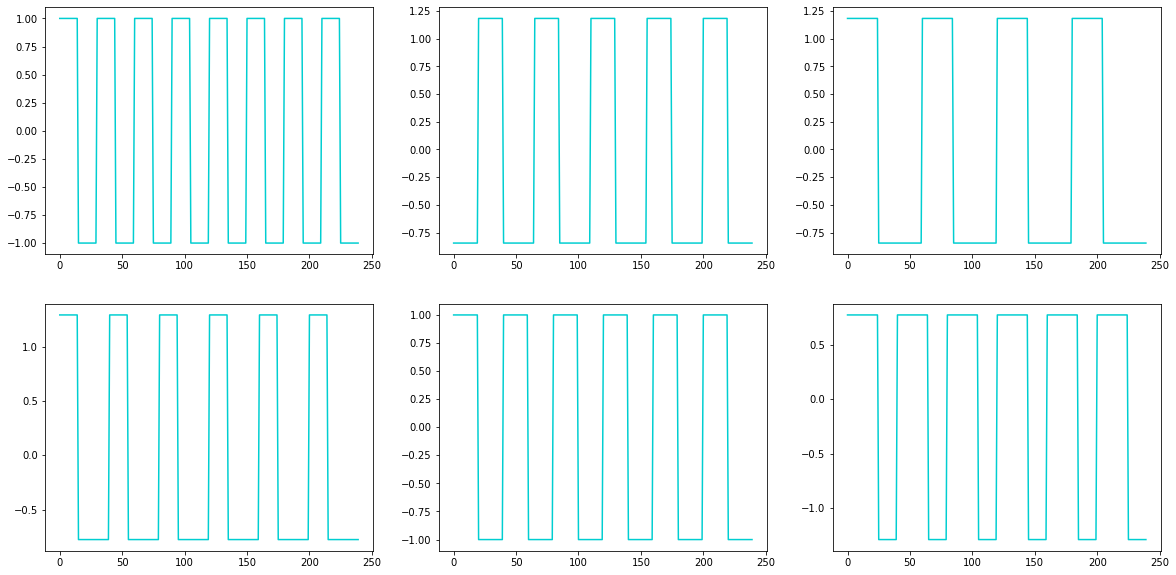

In [6]:
# plotting the graphs
x = range(N)
fig = plt.figure()

fig.set_figheight(10)
fig.set_figwidth(20)
TCcolor = "darkturquoise"

for i in range(nsrcs):
    ax = fig.add_subplot(231+i) 
    ax.plot(x, TCLNormalised[i], color = TCcolor)
plt.show()

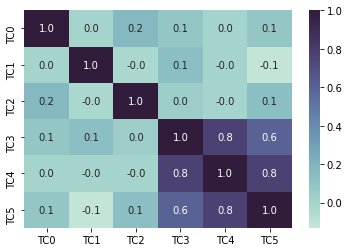

In [7]:
# plot correlation matrix for TC data
TCdf = pd.DataFrame(TC, columns = ["TC0", "TC1", "TC2", "TC3", "TC4", "TC5"])
corr_mat = TCdf.corr()
TCcmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
sns.heatmap(corr_mat, cmap=TCcmap, annot = True, fmt='.1f')

plt.show()

In [22]:
# create SM data
def createSM(vs, hs):
    SM = np.zeros((x1, x2), dtype=int)
    for i in range(x1):
        for j in range(x2):
            if i in range(hs[0], hs[1]) and j in range(vs[0], vs[1]):
                SM[i][j] = 1
    return SM

tmpSM = []
tmpSM.append(createSM([2, 6], [2,6]))
tmpSM.append(createSM([2, 6], [15, 19]))
tmpSM.append(createSM([8, 13], [2, 6]))
tmpSM.append(createSM([8, 13], [15, 19]))
tmpSM.append(createSM([15, 19], [2, 6]))
tmpSM.append(createSM([15, 19], [15, 19]))

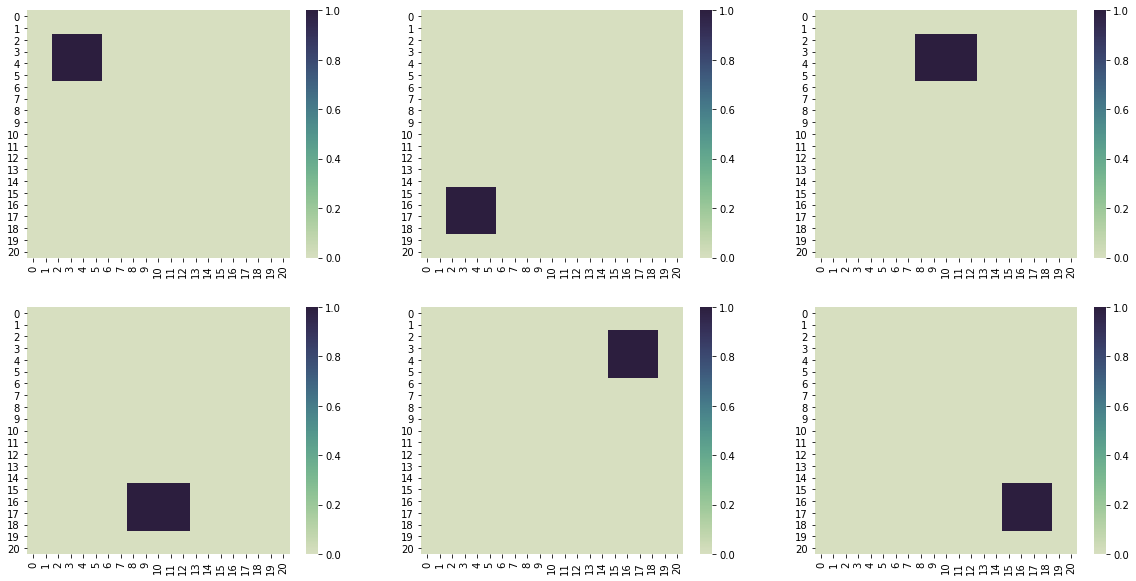

In [23]:
SMcmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
fig = plt.figure()

fig.set_figheight(10)
fig.set_figwidth(20)
plt.xlim=(0,22)
plt.ylim=(0,22)

for i in range(nsrcs):
    ax = fig.add_subplot(231+i) 
    sns.heatmap(tmpSM[i], cmap=SMcmap)
plt.show()

In [24]:
# flatten each small SM matrix to create final SM
SM = []
for i in range(nsrcs):
    SM.append(tmpSM[i].flatten())
SM = np.asmatrix(SM)

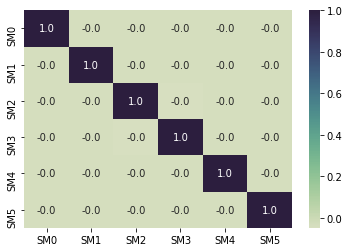

In [25]:
# plot correlation matrix for SM data
SMdf = pd.DataFrame(SM.transpose(), columns = ["SM0", "SM1", "SM2", "SM3", "SM4", "SM5"])
corr_mat = SMdf.corr()
sns.heatmap(corr_mat, cmap=SMcmap, annot = True, fmt='.1f')

plt.show()

In [26]:
# generate white Gaussian noise for TC and SM
mu = 0
varTC = 0.25
varSM = 0.015
TCnoise = np.random.normal(mu, math.sqrt(varTC), size = N*nsrcs)
GammaTC = TCnoise.reshape(240,6)
SMnoise = np.random.normal(mu, math.sqrt(varSM), size = nsrcs*V)
GammaSM = SMnoise.reshape(6, 441)

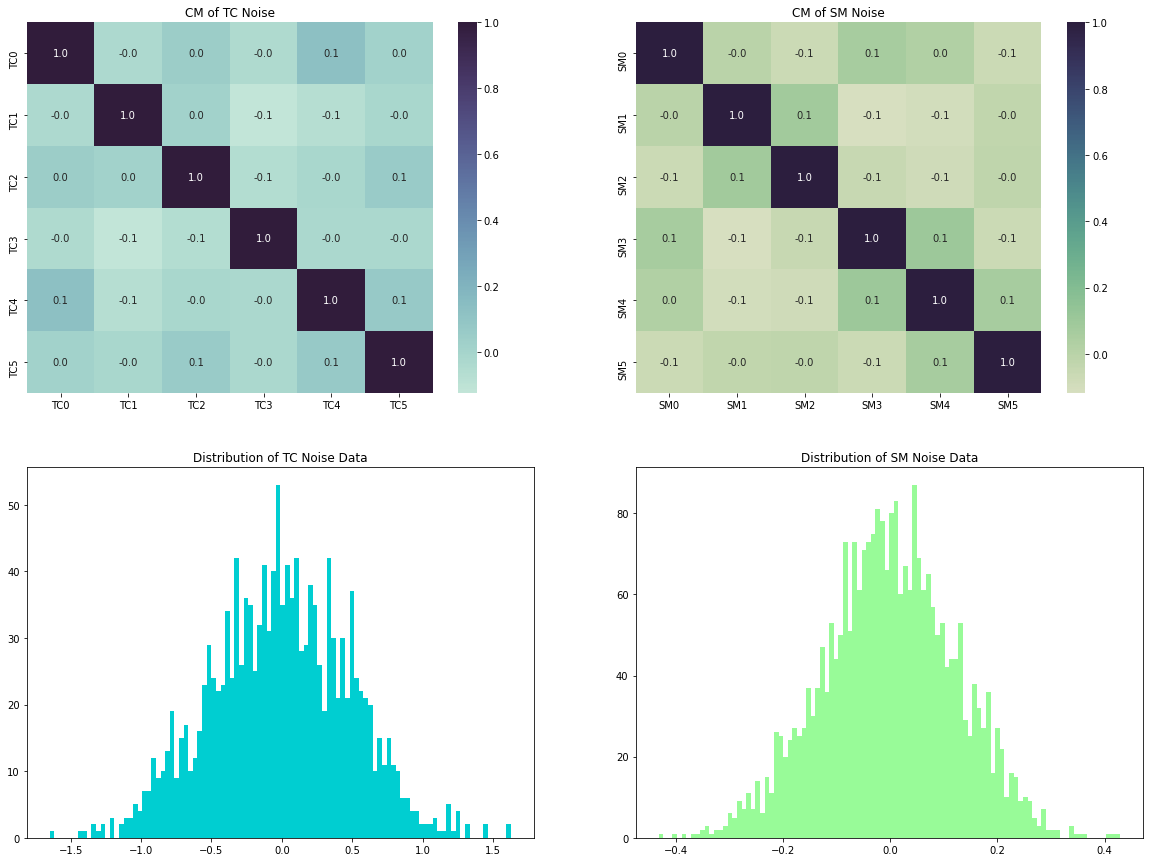

In [69]:
# plot correlation matrix for TC and SM noise
GammaTCdf = pd.DataFrame(GammaTC, columns = ["TC0", "TC1", "TC2", "TC3", "TC4", "TC5"])
GammaTCcorr_mat = GammaTCdf.corr()
GammaSMdf = pd.DataFrame(GammaSM.transpose(), columns = ["SM0", "SM1", "SM2", "SM3", "SM4", "SM5"])
GammaSMcorr_mat = GammaSMdf.corr()

fig, axes = plt.subplots(2, 2) 
fig.set_figheight(15)
fig.set_figwidth(20)



sns.heatmap(GammaTCcorr_mat, cmap=TCcmap, annot = True, fmt='.1f', ax = axes[0][0])
axes[0][0].set_title("CM of TC Noise")
sns.heatmap(GammaSMcorr_mat, cmap=SMcmap, annot = True, fmt='.1f', ax = axes[0][1])
axes[0][1].set_title("CM of SM Noise")
axes[1][0].hist(TCnoise, bins=100, color = "darkturquoise")
axes[1][0].set_title("Distribution of TC Noise Data")
axes[1][1].hist(SMnoise, bins=100, color = "palegreen")
axes[1][1].set_title("Distribution of SM Noise Data")

plt.show()

In [28]:
GammaTCSM = np.matmul(GammaTC, GammaSM)

In [30]:
X = np.matmul(GammaTC + TC, GammaSM + SM)
TCGammaSM = np.matmul(TC, GammaSM)
SMGammaTC = np.matmul(GammaTC, SM)
print(X.shape)

(240, 441)


In [55]:
sampleX = random.sample(range(0, V), 100)
sampleXdf = pd.DataFrame(np.take(X, sampleX, 1).transpose())
sampleXdf["index"] = sampleXdf.index

In [56]:
sampleXdf

,0,1,2,3,4,5,6,7,8,9,...,231,232,233,234,235,236,237,238,239,index
0,0.143089,-0.079291,0.100033,0.254231,0.289389,-0.190619,-0.056811,0.106457,0.334205,0.107112,...,-0.036527,-0.066989,-0.202795,-0.331854,0.018284,0.053914,-0.047319,-0.338708,-0.288818,0
1,0.510484,0.394557,0.500399,0.823995,0.610796,0.570380,0.958548,0.830251,0.933569,0.522316,...,-0.254294,-0.113059,-0.331435,-0.460602,-0.331093,-0.028723,-0.218878,-0.290287,-0.278501,1
2,-0.310069,-0.450878,-0.741633,-0.695409,-0.333960,-0.442045,-0.859346,-0.434479,-0.615386,-0.542823,...,0.263026,0.351317,0.385368,0.386442,0.292352,0.390996,0.366002,0.383257,0.155388,2
3,0.179931,0.276296,0.232912,0.374721,0.307453,0.326059,0.317576,0.350283,0.442033,0.285820,...,-0.196510,-0.151635,-0.142670,-0.235398,-0.201146,-0.156567,-0.184906,-0.176737,-0.145831,3
4,-0.299439,-0.163744,-0.190670,-0.488352,-0.166403,-0.212332,-0.706109,-0.528698,-0.331986,-0.317227,...,-0.068174,-0.268342,-0.082826,-0.020539,-0.030511,-0.318310,-0.051472,-0.132312,-0.174563,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.747111,1.439095,1.142977,1.753538,1.417998,1.710298,1.608420,1.756585,2.360662,1.141098,...,-1.031835,-0.667853,-0.586057,-1.027396,-0.878566,-0.837435,-0.994477,-0.577569,-0.426717,95
96,-0.349102,-0.271580,-0.476356,-0.326198,-0.140823,-0.601520,-0.955232,-0.361952,-0.164245,-0.381809,...,0.139091,0.254981,0.366102,0.170208,0.474692,0.216726,0.097371,0.185086,0.237690,96
97,0.994878,0.920550,2.576136,1.479309,0.850665,1.495301,3.032117,0.898388,1.819939,0.900733,...,-0.939046,-1.625179,-2.104118,-1.534632,-1.387549,-1.656976,-1.109458,-1.486621,-1.153600,97
98,0.617906,1.057658,1.014951,1.337679,1.041755,1.334213,1.466990,1.339272,1.838251,0.807029,...,-0.780501,-0.547213,-0.580205,-0.817782,-0.706604,-0.670762,-0.762534,-0.456791,-0.347741,98


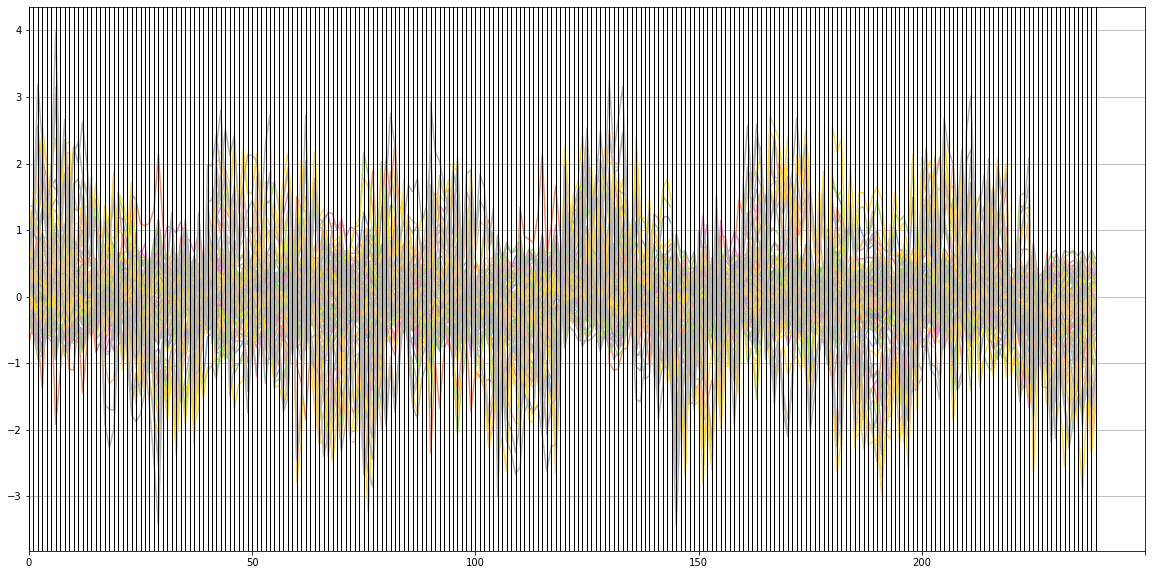

In [65]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)
parallel_coordinates(sampleXdf, "index", colormap=plt.get_cmap("Set2"))
plt.xticks([0, 50, 100, 150, 200, 250])
plt.legend().remove() 
plt.show()